In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

## 신경망을 이용한 예측 : 회귀문제

### 주택 가격 예측

- 1970년 중반 보스턴 주택 가격 데이터셋
- 데이터 506개: 훈련 샘플-404개, 테스트 샘플-102개
- 14개 변수
  - CRIM : 자치시(town) 별 1인당 범죄율
  - ZN : 25,000 평방피트를 초과하는 거주지역의 비율
  - INDUS : 비소매상업지역이 점유하고 있는 토지의 비율
  - CHAS : 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
  - NOX : 10ppm 당 농축 일산화질소
  - RM :  주택 1가구당 평균 방의 개수
  - AGE : 1940년 이전에 건축된 소유주택의 비율
  - DIS : 5개의 보스턴 직업센터까지의 접근성 지수
  - RAD : 방사형 도로까지의 접근성 지수
  - TAX : 10,000 달러 당 재산세율
  - PTRATIO : 자치시(town)별 학생/교사 비율
  - B : 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함
  - LSTAT : 모집단의 하위계층의 비율(%)
  - MEDV : 본인 소유의 주택가격(중앙값) (단위: $1,000)

### 데이터 로드

In [3]:
from keras.datasets import boston_housing

In [5]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [8]:
np.min(train_targets), np.max(train_targets)

(5.0, 50.0)

=> 주택가격(targets): 천달러 단위

### 데이터 준비

- 데이터 표준화
  - 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 발생
  - 입력 데이터에 있는 각 특성을 평균은 0, 표준편차 1이 되도록 표준화함

In [9]:
train_data.mean(axis=0)

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [10]:
train_data.std(axis=0)

array([9.22929073e+00, 2.37382770e+01, 6.80287253e+00, 2.40939633e-01,
       1.17147847e-01, 7.08908627e-01, 2.79060634e+01, 2.02770050e+00,
       8.68758849e+00, 1.66168506e+02, 2.19765689e+00, 9.39946015e+01,
       7.24556085e+00])

In [11]:
# 데이터 표준화(평균= 0, 표준편차= 1)
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [12]:
train_data.mean(axis=0)

array([-1.01541438e-16,  1.09923072e-17,  1.74337992e-15, -1.26686340e-16,
       -5.25377321e-15,  6.41414864e-15,  2.98441140e-16,  4.94653823e-16,
        1.12671149e-17, -1.98136337e-16,  2.36686358e-14,  5.95679996e-15,
        6.13920356e-16])

In [13]:
train_data.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### 1) 신경망 모델 정의 및 컴파일

- 샘플 개수가 적으므로 64개 유닛을 가진 2개의 은닉층으로 네트워크 구성
    - 샘플 수가 적은 경우 모델의 과적합을 예방하기 위해 모델을 복잡하지 않게 구성
    - 보통 은닉층 1~2개 정도로 구성

- 모델 정의 및 컴파일을 위한 함수 생성 build_model()

In [15]:
# relu -> 입력값이 0보다 크면 그대로 출력, 그렇지 않으면 0을 출력
from keras import models, layers

def build_housing_model():
    model = keras.Sequential([layers.Dense(64, activation='relu'),
                             layers.Dense(64,activation='relu'),
                             layers.Dense(1)])
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model

### 2) 모델 훈련 및 검증

**K-fold cross-validation을 사용**

In [21]:
k=4
n_epochs = 100
n_val_samples = len(train_data) // k
all_scores = []

for i in range(k):
    val_x = train_data[i * n_val_samples: (i+1) * n_val_samples]
    val_y = train_targets[i * n_val_samples: (i+1) * n_val_samples]
    part_train_x = np.concatenate([train_data[: i * n_val_samples], train_data[(i+1) * n_val_samples:]], 
                                     axis= 0 )
    part_train_y = np.concatenate([train_targets[: i * n_val_samples], train_targets[(i+1) * n_val_samples:]], 
                                     axis= 0 )
    model = build_housing_model()
    model.fit(part_train_x, part_train_y, epochs= n_epochs, batch_size= 16, verbose= 0)
    val_mse, val_mae = model.evaluate(val_x, val_y)
    all_scores.append(val_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9211 - mae: 2.0077  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10.9755 - mae: 2.6545  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.7427 - mae: 2.5684  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.4791 - mae: 2.4879  


In [22]:
all_scores

[2.0138566493988037, 2.599287509918213, 2.527527093887329, 2.371401309967041]

In [24]:
print(f'평균 MAE: {np.mean(all_scores):.4f}')

평균 MAE: 2.3780


- 각 폴드에서 검증 점수를 로그에 저장하기

  - epochs를 500으로 하여 다시 훈련하여 검증

In [25]:
# epochs = cv -> 반복횟수
k=4
n_epochs = 500
n_val_samples = len(train_data) // k
all_scores = []

for i in range(k):
    val_x = train_data[i * n_val_samples: (i+1) * n_val_samples]
    val_y = train_targets[i * n_val_samples: (i+1) * n_val_samples]
    part_train_x = np.concatenate([train_data[: i * n_val_samples], train_data[(i+1) * n_val_samples:]], 
                                     axis= 0 )
    part_train_y = np.concatenate([train_targets[: i * n_val_samples], train_targets[(i+1) * n_val_samples:]], 
                                     axis= 0 )
    model = build_housing_model()
    history = model.fit(part_train_x, part_train_y, validation_data= (val_x, val_y), 
              epochs= n_epochs, batch_size= 16, verbose= 0)
    
    all_scores.append(history.history['val_mae'])

In [33]:
print(f'평균 MAE: {np.mean(all_scores):.4f}')
len(all_scores), len(all_scores[0])

평균 MAE: 2.5657


(4, 500)

### 3) 모델 성능 시각화

In [36]:
def draw_metric_plot(history):
    loss = ['loss','val_loss']
    mae = ['mae','val_mae']
    title = ['Loss', 'Accuracy']
    plt.figure(figsize=(10,4))
    
    for i, item in enumerate([loss, mae]):
        n = len(history.history[item[0]])
        plt.subplot(1,2, i+1)
        plt.plot(history.history[item[0]], label= 'train')
        plt.plot(history.history[item[1]], label= 'validation')
        plt.xlabel('epochs')
        plt.ylabel(title[i])
        plt.title(title[i] + ' plot')
        plt.legend()    
        plt.tight_layout()
        plt.grid()
    plt.show()

- 마지막 폴드에 대한 성능 시각화

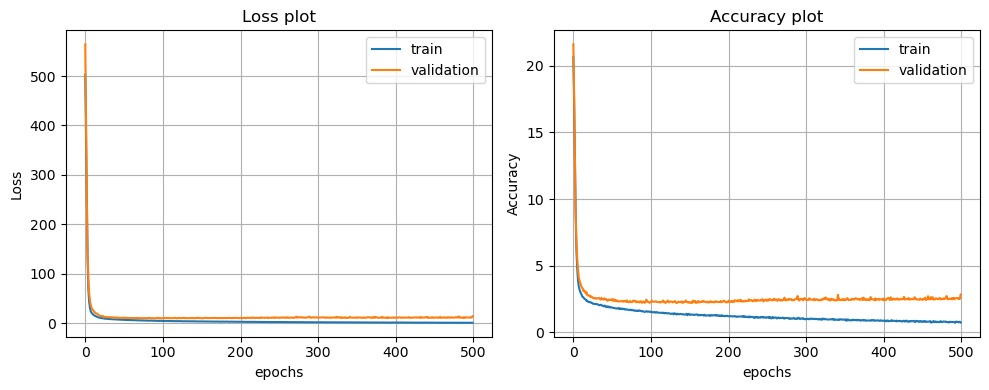

In [37]:
draw_metric_plot(history)

- 모든 폴드에 대해 에포크별 MAE 평균점수

In [42]:
avg_mae_hist = [np.mean([x[i] for x in all_scores]) for i in range(n_epochs)]

In [43]:
np.min(avg_mae_hist), np.max(avg_mae_hist)

(2.2129393219947815, 18.943944454193115)

In [44]:
# 값에 해당하는 epochs 수
np.argmin(avg_mae_hist), np.argmax(avg_mae_hist)

(134, 0)

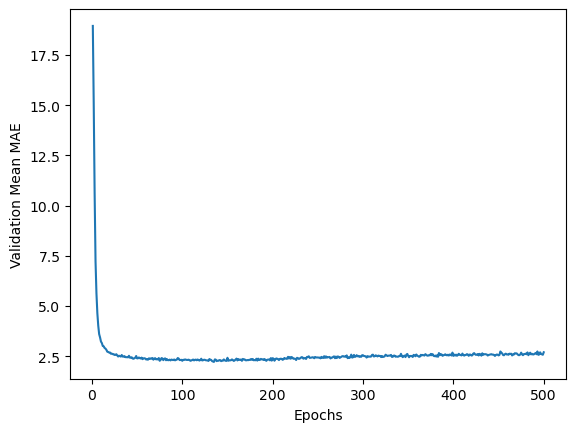

In [46]:
plt.plot(range(1, len(avg_mae_hist)+ 1), avg_mae_hist)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean MAE')
plt.show()

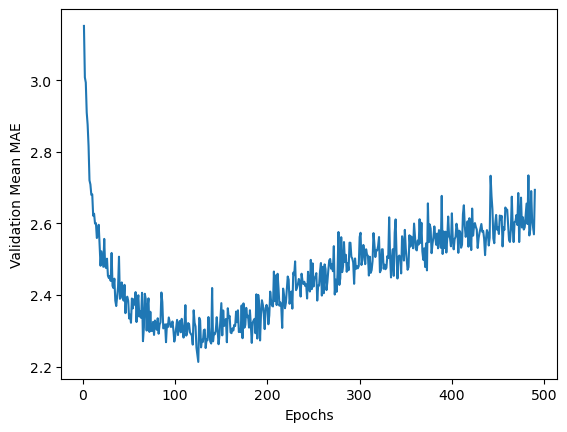

In [47]:
part_mae_hist = avg_mae_hist[10:]
plt.plot(range(1, len(part_mae_hist)+ 1), part_mae_hist)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean MAE')
plt.show()

### 4) 최종 모델 훈련하기

- 에포크수, 은닉층의 크기 등 모델의 여러 매개변수에 대한 튜닝이 끝나면 모든 훈련데이터를 사용하여 모델을 훈련함

In [48]:
model = build_housing_model()
model.fit(train_data, train_targets, epochs= 130, batch_size= 16, verbose= 0)

### 5) 테스트 데이터로 성능 확인

In [49]:
test_mse, test_mae = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.2307 - mae: 2.6610  


In [50]:
print(f'테스트 데이터 MSE: {test_mse:.4f}, 테스트 데이터 MAE: {test_mae:.4f}')

테스트 데이터 MSE: 18.8222, 테스트 데이터 MAE: 2.8249


### 6) 새로운 데이터에 대해 예측

In [53]:
pred_y = model.predict(test_data)
test_targets[0], pred_y[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(7.2, array([10.565947], dtype=float32))

----

## [정리]

- 회귀는 분류에서 사용했던 것과 다른 손실함수 사용 : 평균제곱오차(MSE)
- 회귀에서 사용되는 평가지표 : 평균절대오차(MAE)
- 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일링해야 함 -> 정규화
- 가용한 데이터가 적다면 K-fold 교차검증을 사용하는 것이 신뢰할 수 있는 모델 평가방법임
- 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층의 수를 줄임 모델이 좋음(일반적으로 1개 또는 2개)

### 연습문제.

1. 위 모델에서 최적화 알고리즘을 'Adam'을 사용한 경우 모델을 학습하고 평가하여 결과를 비교해보세요.


2. 학습의 epochs수와 batch사이즈를 조절하여 결과를 모델 성능을 비교하세요.


3. 2개의 은닉층과 1개의 출력층을 갖는 모델을 구성하고 최적화는 'rmsprop'을 적용한 경우와 'adam'을 적용한 경우를 비교해보시오.


4. 위의 모델에서 콜백함수의 Early stopping 기법을 적용하여 최적의 epoch가 언제인지 찾아내시오.

In [55]:
def build_housing_model_adam():
    model = Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)

In [57]:
# 모델 학습 ~ 시각화
def model_fit_plot(train_data, train_targets, model, epochs, batch_size):
    model = model()
    history = model.fit(train_data, train_targets, 
                        epochs=epochs, batch_size=batch_size, 
                        validation_split=0.2, 
                        callbacks=[early_stopping], 
                        verbose=0)
    
    draw_metric_plot(history)

In [ ]:
# epochs 100 , batch_size= 16

model2 = build_housing_model_adam()
model_fit_plot(train_data, train_targets, model, epochs= 100, batch_size= 16)

In [ ]:
# epochs 100 -> 200

model2 = build_housing_model_adam()
model_fit_plot(train_data, train_targets, model, epochs= 200, batch_size= 16)

In [ ]:
# epochs 100, batch_size 16 -> 32
model2 = build_housing_model_adam()
model_fit_plot(train_data, train_targets, model, epochs= 100, batch_size= 32)

In [ ]:
# epochs 100 -> 200, batch_size 16 -> 32
model2 = build_housing_model_adam()
model_fit_plot(train_data, train_targets, model, epochs= 200, batch_size= 32)

In [ ]:
# Adam 최적의 에포크 출력
print(f'Adam 최적의 에포크: {np.argmin(history.history['val_loss']) + 1}')

# 모델 평가
test_mse, test_mae = model.evaluate(test_data, test_targets)
print(f'Test MAE: {test_mae:.4f}')

---